In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random

# learners 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# decomposition
from sklearn.decomposition import NMF, PCA


# metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

# data
from sklearn.datasets import fetch_lfw_people

# misc
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split

plt.rcParams['image.cmap'] = "gray"
%matplotlib inline

### Load data

In [2]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
f"# imgs: {people.data.shape[0]} | Imgs shape: {people.images[0].shape}"

'# imgs: 3023 | Imgs shape: (87, 65)'

In [3]:
# know thy data
print(people["DESCR"])

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

#### Inspect images

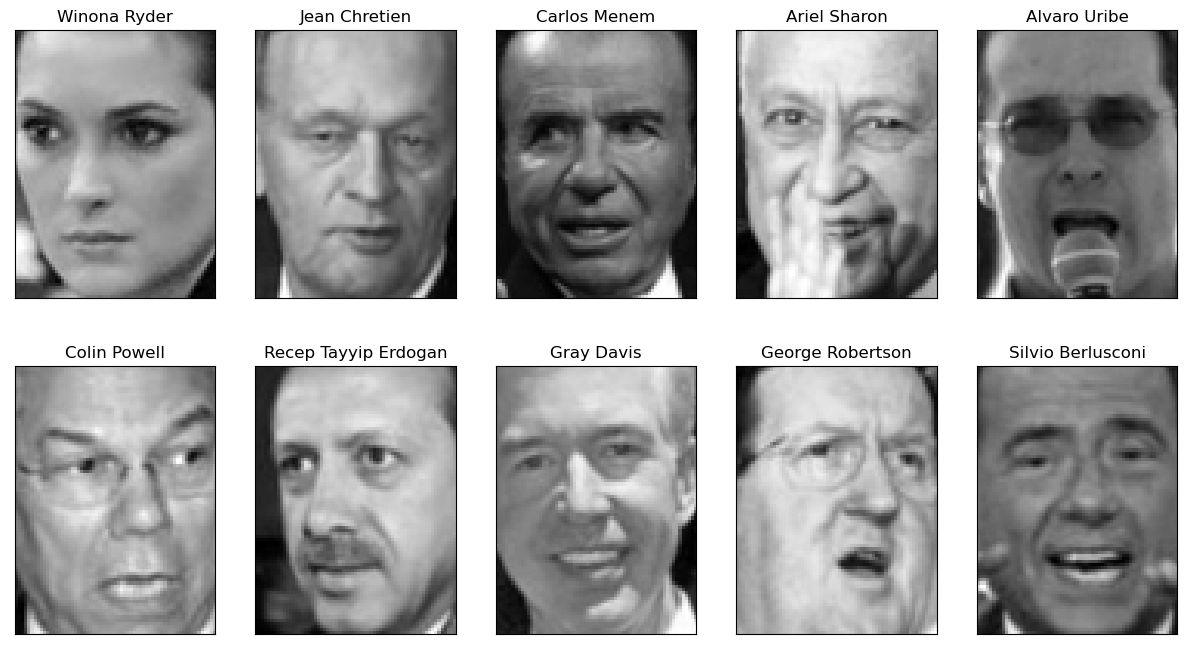

In [4]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=5, 
    figsize=(15, 8),
    subplot_kw={
        'xticks': (), 
        'yticks': ()
    }
)
for target, image, ax in zip(
    people.target, 
    people.images, 
    axes.ravel()
):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

### Filter and split images and targets

In [5]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

# Question 0

## 0.1 train-test split
- Do a train_test_split of the data. Make sure you use the stratify option, to ensure the same distribution of people in training and test data



In [6]:
# split the data in training and test set
(
    X_train,
    X_test,
    y_train,
    y_test
) = train_test_split(
    X_people,
    y_people,
    stratify=y_people,
    random_state=0
)
# shape of dataset
X_train.shape, X_test.shape

((1547, 5655), (516, 5655))

## 0.2 Target distribution
- Print the target distribution (value counts) for y_train (Consider what insights we can draw from this)

In [7]:
# Target distribution
vc = (
    pd.Series(y_train) 
    .map(pd.Series(people.target_names))
    .value_counts()
)
vc

John Ashcroft        37
Jean Chretien        37
Tony Blair           37
Jacques Chirac       37
George W Bush        37
                     ..
Paul Bremer          15
Jiang Zemin          15
Michael Bloomberg    15
Igor Ivanov          15
Angelina Jolie       15
Length: 62, dtype: int64

<AxesSubplot: >

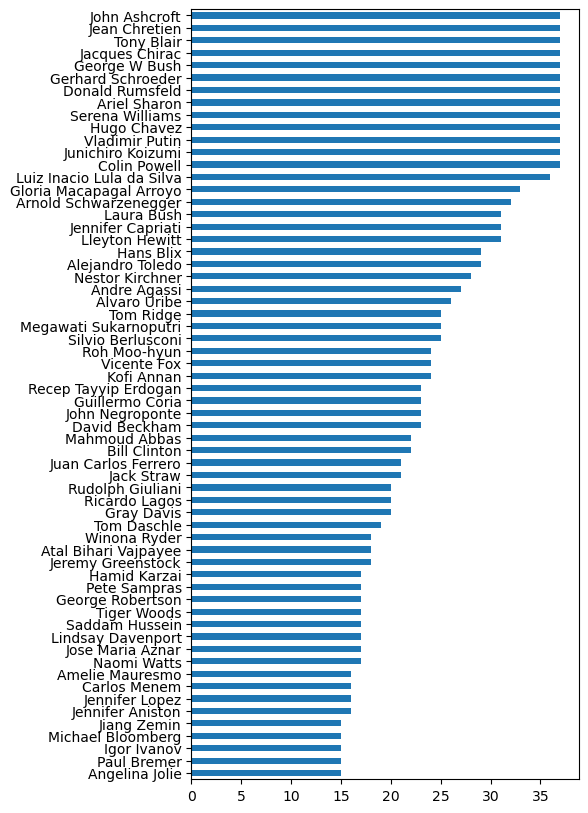

In [8]:
vc.sort_values().plot(kind="barh", figsize=(5, 10))

### Insights from the target distribution
Most learning algorithms assume that we have equally distributed data. In situations with class imbalance, the algorithm tends to develop a bias towards classes the occur more frequently. This, in turn, can lead to poor performance on the less frequent classes. In essence, this happens because learning algorithms are concerned with decreasing error rates, not class distributions: Computationally, it just makes more sense to focus on the larger fish.


In our case, we have classes with more than double the examples of other classes. A priori, we may assume that our ML models will perform better on the classes with high frequency. This, of course, will also depend on the features themselves - If a clear pattern can be observed for a class with just a few examples, the algorithm could decrease it's error rate by "remembering" this pattern. Here, however, the class imbalance is not particularly concerning.

Read more about the multiclass imbalance problem [here](https://machinelearningmastery.com/multi-class-imbalanced-classification/)

### Visualizer class 
To get a visual feel for the performance of our models, we create a class that can show the predicted class, the true class and the top N confidence distribution.

In [9]:
class Visualizer:

    def __init__(
        self,
        imgs,
        targets,
        img_shape = people.images[0].shape,
        names = people.target_names
    ) -> None:
    
        self.img_shape = img_shape
        self.names = names
        self.imgs = imgs
        self.targets = targets

    def __call__(self, clf: object, X : np.array) -> None:

        try:
            self.N = random.randint(0, X_test.shape[0])
            ppl_probas = clf.predict_proba([X[self.N]])[0]
            self.generate_plot(ppl_probas, self.N)
        except AttributeError:
            print("Estimator doesn't have predict_proba")
        except NotFittedError:
            print("Estimator is not fitted")
        
    def sample_img_class(self, probas : np.array) -> int:
        return random.sample(
            np.where(self.targets == np.argmax(probas))[0].tolist(), 
            k=1
        )

    def get_top_n(self, probas : np.array, k=5) -> tuple:
        ind = np.argsort(probas)[::-1][:k]
        labels = np.array(self.names)[ind]
        top_probs = probas[ind]
        return labels, top_probs

    def gen_img_plot(self, imshow : np.array, title : str) -> None:
        plt.imshow(imshow.reshape(self.img_shape))
        plt.xticks(())
        plt.yticks(())
        plt.title(title)

    def generate_plot(self, probas : np.array, N : int) -> None:
        
        gs = gridspec.GridSpec(2, 2)
        plt.figure()

        plt.subplot(gs[0, 0]) # row 0, col 0
        self.gen_img_plot(
            imshow = self.imgs[N],
            title = (
                f"True class:\n {self.names[self.targets[N]]}" +
                f" - {probas[self.targets[N]]:.3f}%"
            )
        )
        plt.subplot(gs[0, 1]) # row 0, col 1
        same_class = self.sample_img_class(probas)
        self.gen_img_plot(
            imshow = self.imgs[same_class],
            title = (
                f"Predicted class:\n {self.names[np.argmax(probas)]}" +
                f" - {np.max(probas):.3f}%"
            )
        )
        plt.subplot(gs[1, :]) # row 1, span all columns
        labels, top_probs = self.get_top_n(probas, k=10)
        plt.bar(labels, top_probs)
        plt.xticks(
            rotation=45,
            horizontalalignment='right',
        )
        plt.ylim(0, 1);

visualizer = Visualizer(X_test, y_test)

# Question 1

- Build a baseline model to compare our performance against, using sklearn's `DummyClassifier`. Fit it on (X_train, y_train) and evaluate on (X_test, y_test)


In [ ]:
# Defining model and fitting to training set
clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)

# Printing test scores
print(f"Test set score: {clf.score(X_test, y_test):.2f}")

Test set score: 0.03


- *Comment:* NO value that occurs more than x times - 

- Build both a K Nearest Neighbors and a Logistic Regression model. Fit and evaluate on the same data as above. For the KNN model, set the paramter `n_neighbors` to **1**. 


In [11]:
# Defining model and fitting to training set
knn = KNeighborsClassifier(
    n_neighbors=1, 
    weights='uniform'
).fit(X_train, y_train)

# Reporting scores on training and testing set
print(f"Train set score: {knn.score(X_train, y_train):.2f}")
print(f"Test set score: {knn.score(X_test, y_test):.2f}")

Train set score: 1.00
Test set score: 0.22


Does much better than baseline

In [12]:
lr = LogisticRegression(
    solver='lbfgs', 
    multi_class="auto"
).fit(X_train, y_train)

print(f"Train set score: {lr.score(X_train, y_train):.2f}")
print(f"Test set score: {lr.score(X_test, y_test):.2f}")

Train set score: 0.10
Test set score: 0.07


- Compare the two models - Why might a KNN with n_neighbors=1 perform better? (Hint: Consider the bias/variance tradeoff)

#### Model comparison - KNN vs. LR

Setting n_neighbors=1, will give the KNN classifier an extremely irregular (or **overfitted**) decision boundary. In contrast, if one configures `n_neighbors=X_train.shape[0]`, the model will effectively be a "most_frequent" DummyClassifier. Why? Because KNN performs a plurality vote of its neighbors, with the object being assigned to the most common class among the considered neighbors. So, as we decrease n_neighbors all the way to 1, we get closer and closer to a "perfect" model of the data set (low bias), but the model will have higher and higher *variance*.

For our data, that means that we will get (relatively) good performance on the exact same data space, but it will likely be too fitted for a new data space. So good performance on the test set would mean that the test data is neigh identical to the train data. We can also see this by the KNN models ability to gain 100% accuracy on train (as compared to LR's measly 0.10%). In general: Be aware of 100% accuracy - Even of training data. [Read more about the bias/variance tradeoff here](http://scott.fortmann-roe.com/docs/BiasVariance.html)

- n = 1 > complex- very overfitted to data. flexible decision boundary. similar data > get good results, but red flag (overfitting). Therefore, question testing scores

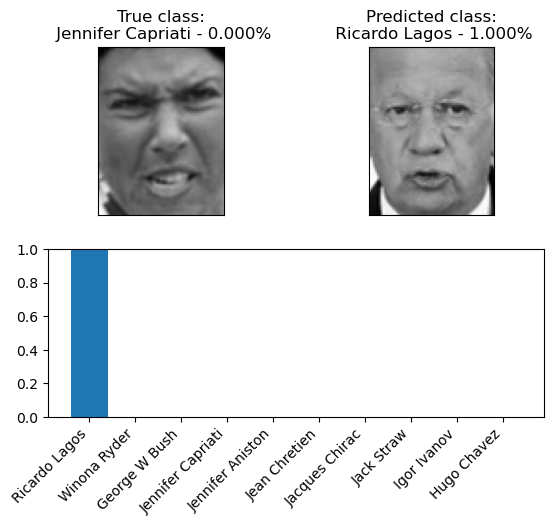

In [14]:
visualizer(clf=knn, X=X_test)

<h1>Question 2</h1>

- Train a PCA model to (X_train, y_train). Select 100 for the number of components.

- Use the PCA model to transform both X_train and X_test. (Consider using `.fit_transform`)
- Plot the 10 (or more) first components as imgs (See section 3.4 - pp. 154 - in the book for this)


In [15]:
pca = PCA(
    n_components=100,
    whiten=True, 
    random_state=0
)
# Both transform train and test data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

f"X_train_pca.shape: {X_train_pca.shape}"

'X_train_pca.shape: (1547, 100)'

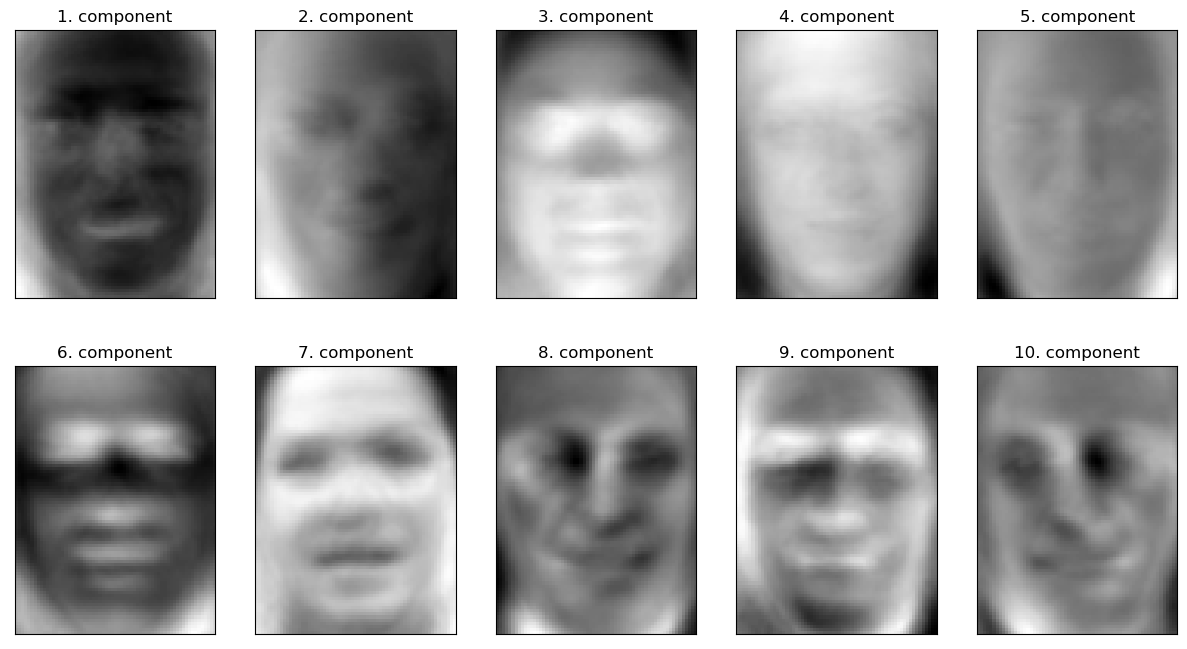

In [16]:
# plot components for single person - visualize components
_, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(15, 8),
    subplot_kw={
        'xticks': (),
        'yticks': ()
    }
)
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(people.images[0].shape))
    ax.set_title(f"{i + 1}. component")

# Question 3
- Build a KNN model with this transformed data, and report on the results on the transformed test data. 

- Then try a Logistic Regression model, and report on the result.

- **Comment on the effect on PCA and why it occurs.**

- Bonus: Try to play around with `n_components` in your PCA model. See what the effect.

In [17]:
knn = KNeighborsClassifier(
    n_neighbors=1,
    weights='uniform'
).fit(X_train_pca, y_train)

print(f"Train set score: {knn.score(X_train_pca, y_train):.2f}")
print(f"Test set score: {knn.score(X_test_pca, y_test):.2f}")

Train set score: 1.00
Test set score: 0.30


- Slightly improvement from 0.22 to 0.30 for the KNN classifier

In [18]:
# print(
#         classification_report(
#         y_test,
#         knn.predict(X_test_pca),
#         target_names=people.target_names,
#         zero_division=0
#     )
# )

In [18]:
lr = LogisticRegression(
    solver='lbfgs', 
    multi_class="auto"
).fit(X_train_pca, y_train)

print(f"Train set score: {lr.score(X_train_pca, y_train):.2f}")
print(f"Test set score: {lr.score(X_test_pca, y_test):.2f}")

Train set score: 1.00
Test set score: 0.49


- Bigger improvement from the initial model without transformed data

#### The effect of PCA
Finding the 100 principal components of the data clearly has a significant effect on the performance of both models, namely the logistic regression. For LR, we increase performance by 390% (10% -> 49% accuracy)

PCA looks to project each example (data point) into a lower-dimensional space while conserving the variation of the data. In our case, it considers each face and asks: What is unique and what is highly correlated between data points. It leverages this information to iteratively discard, weight and eventually combine features. 

The first principal component can equivalently be defined as a direction that maximizes the variance of the projected data. The *i*th principal component can be taken as a direction orthogonal to the first 
*i* - 1 principal components that maximizes the variance of the projected data.



Text(0, 0.5, 'Classes')

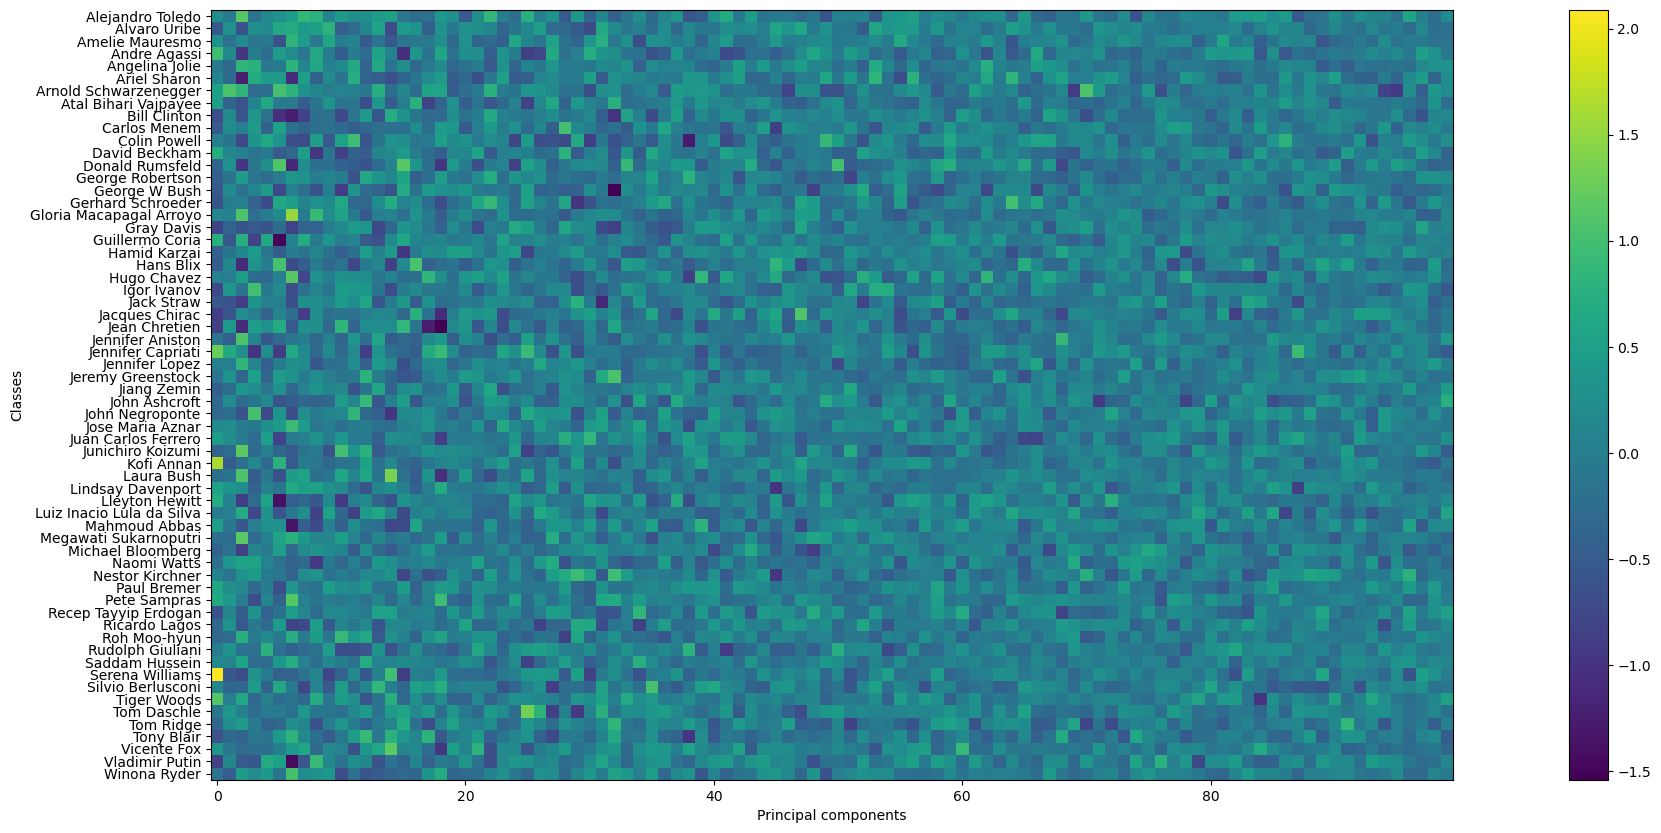

In [20]:
plt.figure(figsize=(30, 10))
plt.imshow(
    lr.coef_,
    cmap='viridis'
)
plt.yticks(
    range(len(people.target_names)),
    people.target_names,
    horizontalalignment='right'
)
plt.colorbar()
plt.xlabel("Principal components")
plt.ylabel("Classes")

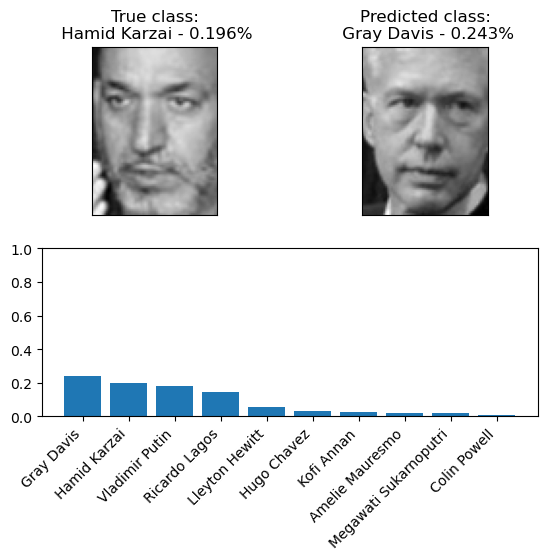

In [21]:
visualizer(clf=lr, X=X_test_pca)

<h1>Question 4</h1>

- Fit NMF components to the train data. Select 100 for the number of components. Use this to transform both X_train and X_test. 
- Use the same technique as from 2 to plot the components as images

- Build both a KNN model and a logistic regression model with this transformed data, and report on the result.

- Bonus: Build a neural network (MLP) - As above

- **Compare the effect of NMF with the effect of PCA**

/opt/homebrew/Caskroom/miniforge/base/envs/aiml-labs/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/aiml-labs/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


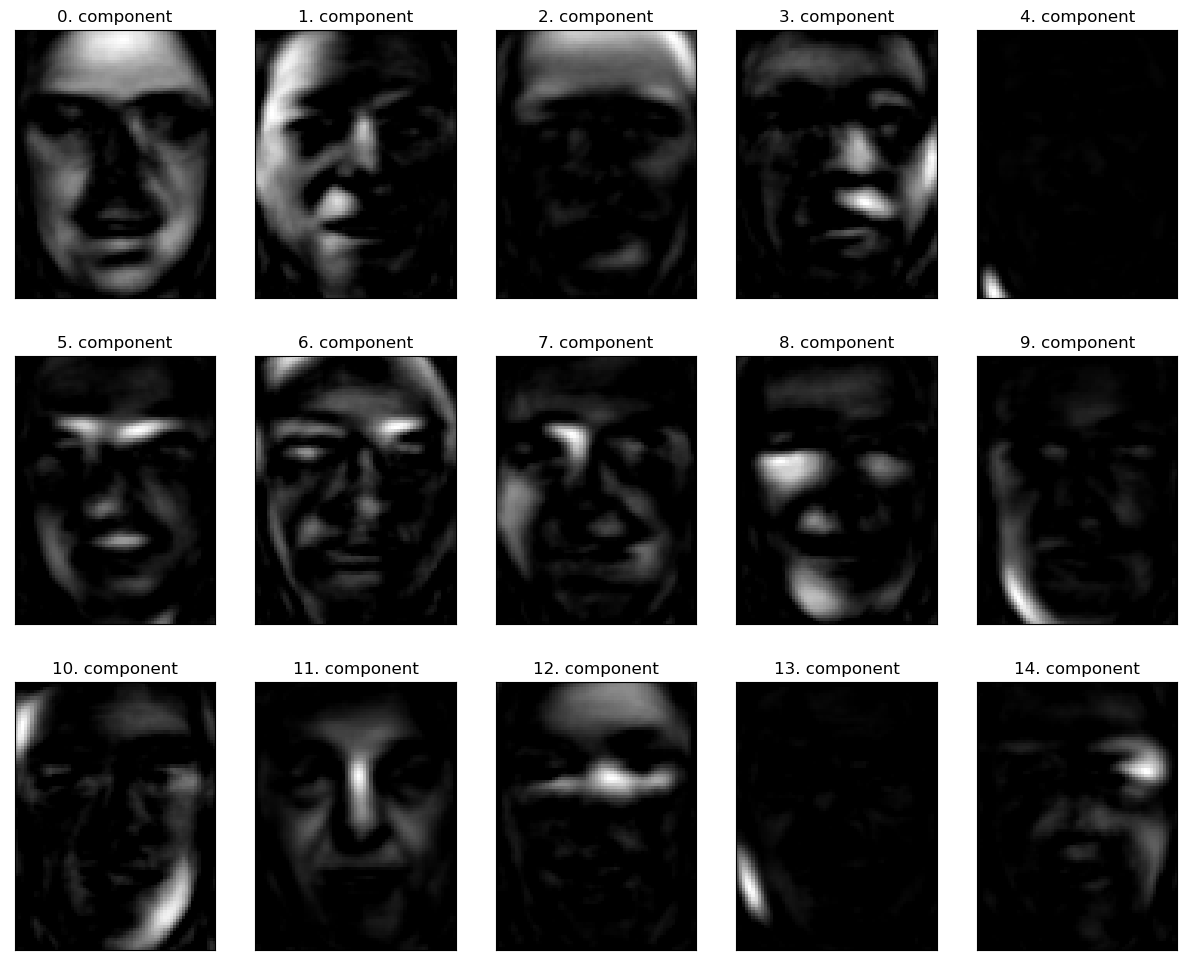

In [46]:

nmf = NMF(n_components=100, random_state=0) 
X_train_nmf = nmf.fit_transform(X_train)
X_test_nmf = nmf.transform(X_test)

# Visualize
fig, axes = plt.subplots(
   3, 
   5, 
   figsize=(15, 12),
   subplot_kw={
      'xticks': (), 
      'yticks': ()
   }
)
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
   ax.imshow(component.reshape(people.images[0].shape))
   ax.set_title("{}. component".format(i))

In [47]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_nmf, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_nmf, y_test)))

Test set accuracy: 0.21


In [48]:
lr = LogisticRegression(solver='lbfgs', multi_class="auto", max_iter=5000)
lr.fit(X_train_nmf, y_train)
print("Test set accuracy: {:.2f}".format(lr.score(X_test_nmf, y_test)))

Test set accuracy: 0.11


- Don't get as good results for this model. 
- Use dimensionality reduction techniques for visualization and performance

#### Comparison of the effect of NMF and PCA

NMF splits the images into a set of *basis images*: features that one could interpret as "nose", "eyes" etc, that, when combined, may approximate the original image. In contrast, PCA projects our data to a lower-dimensional space of "generic" faces ordered by how well they capture the original one.

Unlike PCA, NMF learns to represent faces with a set of basis images resembling parts of faces. Consider component 2, 8, 14 (with random_state=0) - These are parts of a face: A forehead, a chin jaw and two chins. 

# Question 5
Let's enact a real-life case scenario, using the same data. Here, (X_train, y_train) will be the data given to your for the project. (X_test, y_test) will be *next* months batch. **Pretend it is not available to you at training time**. Follow the steps below:

- Make sure you have **ALL** random_states set to 0 (Incl. x_train_test_split's random_state!)

- Split your training data into (X_val, y_val), (X_train, y_train). Remember to set `stratify=True`

- Choose one (or more) learning algorithms discussed in class. 
- Using all techniques used or discussed in class, incl. NMF and PCA (and hyperparamter optimization), train on your (X_train, y_train) and eval the results on (X_val, y_val) - To try build the best model possible
- Show the performance using an accuracy score, confusion matrix and a classification report. 
- Bonus: Report any noteworthy insights (such as class performance imbalances) and write what it might mean for your model in production.
- Fit a model to combined train and val data (i.e. the original X_train) with the best paramters. This is what we will "push to production"

#### Split data

In [49]:
# split X_train into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    random_state=0
)

#### Build model class for efficiency

In [50]:
class Experiment:

    def __init__(self):
         self.results = []

    def run(
        self, 
        clf, 
        param_grid, 
        data, 
        scoring = 'f1_weighted', 
        cv = 3, 
        return_train_score = True, 
        verbose = 1,
        **kwargs
    ):
        gs_clf = GridSearchCV(
            clf,
            param_grid,
            scoring=scoring,
            cv=cv,
            return_train_score=return_train_score,
            verbose=verbose,
            **kwargs
        ).fit(data["X_train"], data["y_train"])

        results = self.log_results(gs_clf, data)
        self.results.append(results)
        if verbose:
            self.print_results(results)

    def log_results(self, clf, data):
        return {
            "algo": clf.best_estimator_.__class__.__name__,
            "best_params": clf.best_params_,
            "train_score": clf.best_score_,
            "test_score": clf.score(data["X_val"], data["y_val"]),
        }

    def print_results(self, results):
        for k, v in results.items():
            print(f"{k}: {v}")

    def run_multiple(self, clfs, param_grids, data, **kwargs):
        for clf, param_grid in zip(clfs, param_grids):
            print(f"Running {clf.__class__.__name__}...")
            self.run(clf, param_grid, data, **kwargs)

        # return results as pandas dataframe
        return pd.DataFrame(self.results)

#### Transform data using PCA

In [51]:
pca = PCA(n_components=200, whiten=True, random_state=0)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
pca

PCA(n_components=200, random_state=0, whiten=True)

#### Define learning algorithms and paramter grids

In [52]:
clfs=[
    RandomForestClassifier(),
    LogisticRegression()
]
param_grids=[
    
    {
        "n_estimators": [100, 500, 1000],
        # define more parameters
    },
    {
        "C": [0.001, 0.1, 1, 10],
        "solver": ["lbfgs", "liblinear"],
        # define more parameters
    }
]
data={
    "X_train": X_train_pca,
    "y_train": y_train,
    "X_val": X_val_pca,
    "y_val": y_val
}


#### Train and evaluate

In [53]:
exp = Experiment()
results_df = exp.run_multiple(
    clfs=clfs,
    param_grids=param_grids,
    data=data,
    verbose=3,
    scoring="accuracy"
)

Running RandomForestClassifier...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END n_estimators=100;, score=(train=1.000, test=0.162) total time=   2.1s
[CV 2/3] END n_estimators=100;, score=(train=1.000, test=0.193) total time=   2.0s
[CV 3/3] END n_estimators=100;, score=(train=1.000, test=0.190) total time=   2.1s
[CV 1/3] END n_estimators=500;, score=(train=1.000, test=0.255) total time=  10.3s
[CV 2/3] END n_estimators=500;, score=(train=1.000, test=0.241) total time=  10.4s
[CV 3/3] END n_estimators=500;, score=(train=1.000, test=0.241) total time=  10.6s
[CV 1/3] END n_estimators=1000;, score=(train=1.000, test=0.272) total time=  20.8s
[CV 2/3] END n_estimators=1000;, score=(train=1.000, test=0.248) total time=  20.7s
[CV 3/3] END n_estimators=1000;, score=(train=1.000, test=0.259) total time=  21.3s
algo: RandomForestClassifier
best_params: {'n_estimators': 1000}
train_score: 0.2597701149425287
test_score: 0.32413793103448274
Running LogisticRegression..

In [54]:
results_df.sort_values(by="test_score", ascending=False, inplace=True)
results_df

,algo,best_params,train_score,test_score
1,LogisticRegression,{'C': 10},0.305747,0.400000
0,RandomForestClassifier,{'n_estimators': 1000},0.259770,0.324138


- The  best model is Logistic Regression

In [55]:
best_results = results_df.iloc[0]
best_clf = LogisticRegression(**best_results["best_params"]).fit(X_train_pca, y_train)
y_pred = best_clf.predict(X_val_pca)
print(classification_report(y_val, y_pred, target_names=people.target_names, zero_division=0))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.50      0.67      0.57         6
             Alvaro Uribe       0.67      0.40      0.50         5
          Amelie Mauresmo       1.00      0.67      0.80         3
             Andre Agassi       0.80      0.80      0.80         5
           Angelina Jolie       0.00      0.00      0.00         3
             Ariel Sharon       0.38      0.43      0.40         7
    Arnold Schwarzenegger       0.17      0.17      0.17         6
     Atal Bihari Vajpayee       0.50      0.33      0.40         3
             Bill Clinton       0.50      0.50      0.50         4
             Carlos Menem       0.50      0.33      0.40         3
             Colin Powell       0.33      0.43      0.38         7
            David Beckham       0.50      0.50      0.50         4
          Donald Rumsfeld       0.23      0.43      0.30         7
         George Robertson       1.00      0.67      0.80     

- tuning using training data, cv on part of data
- After finding our best classifier, we reetrain on all the data! and create a classification report

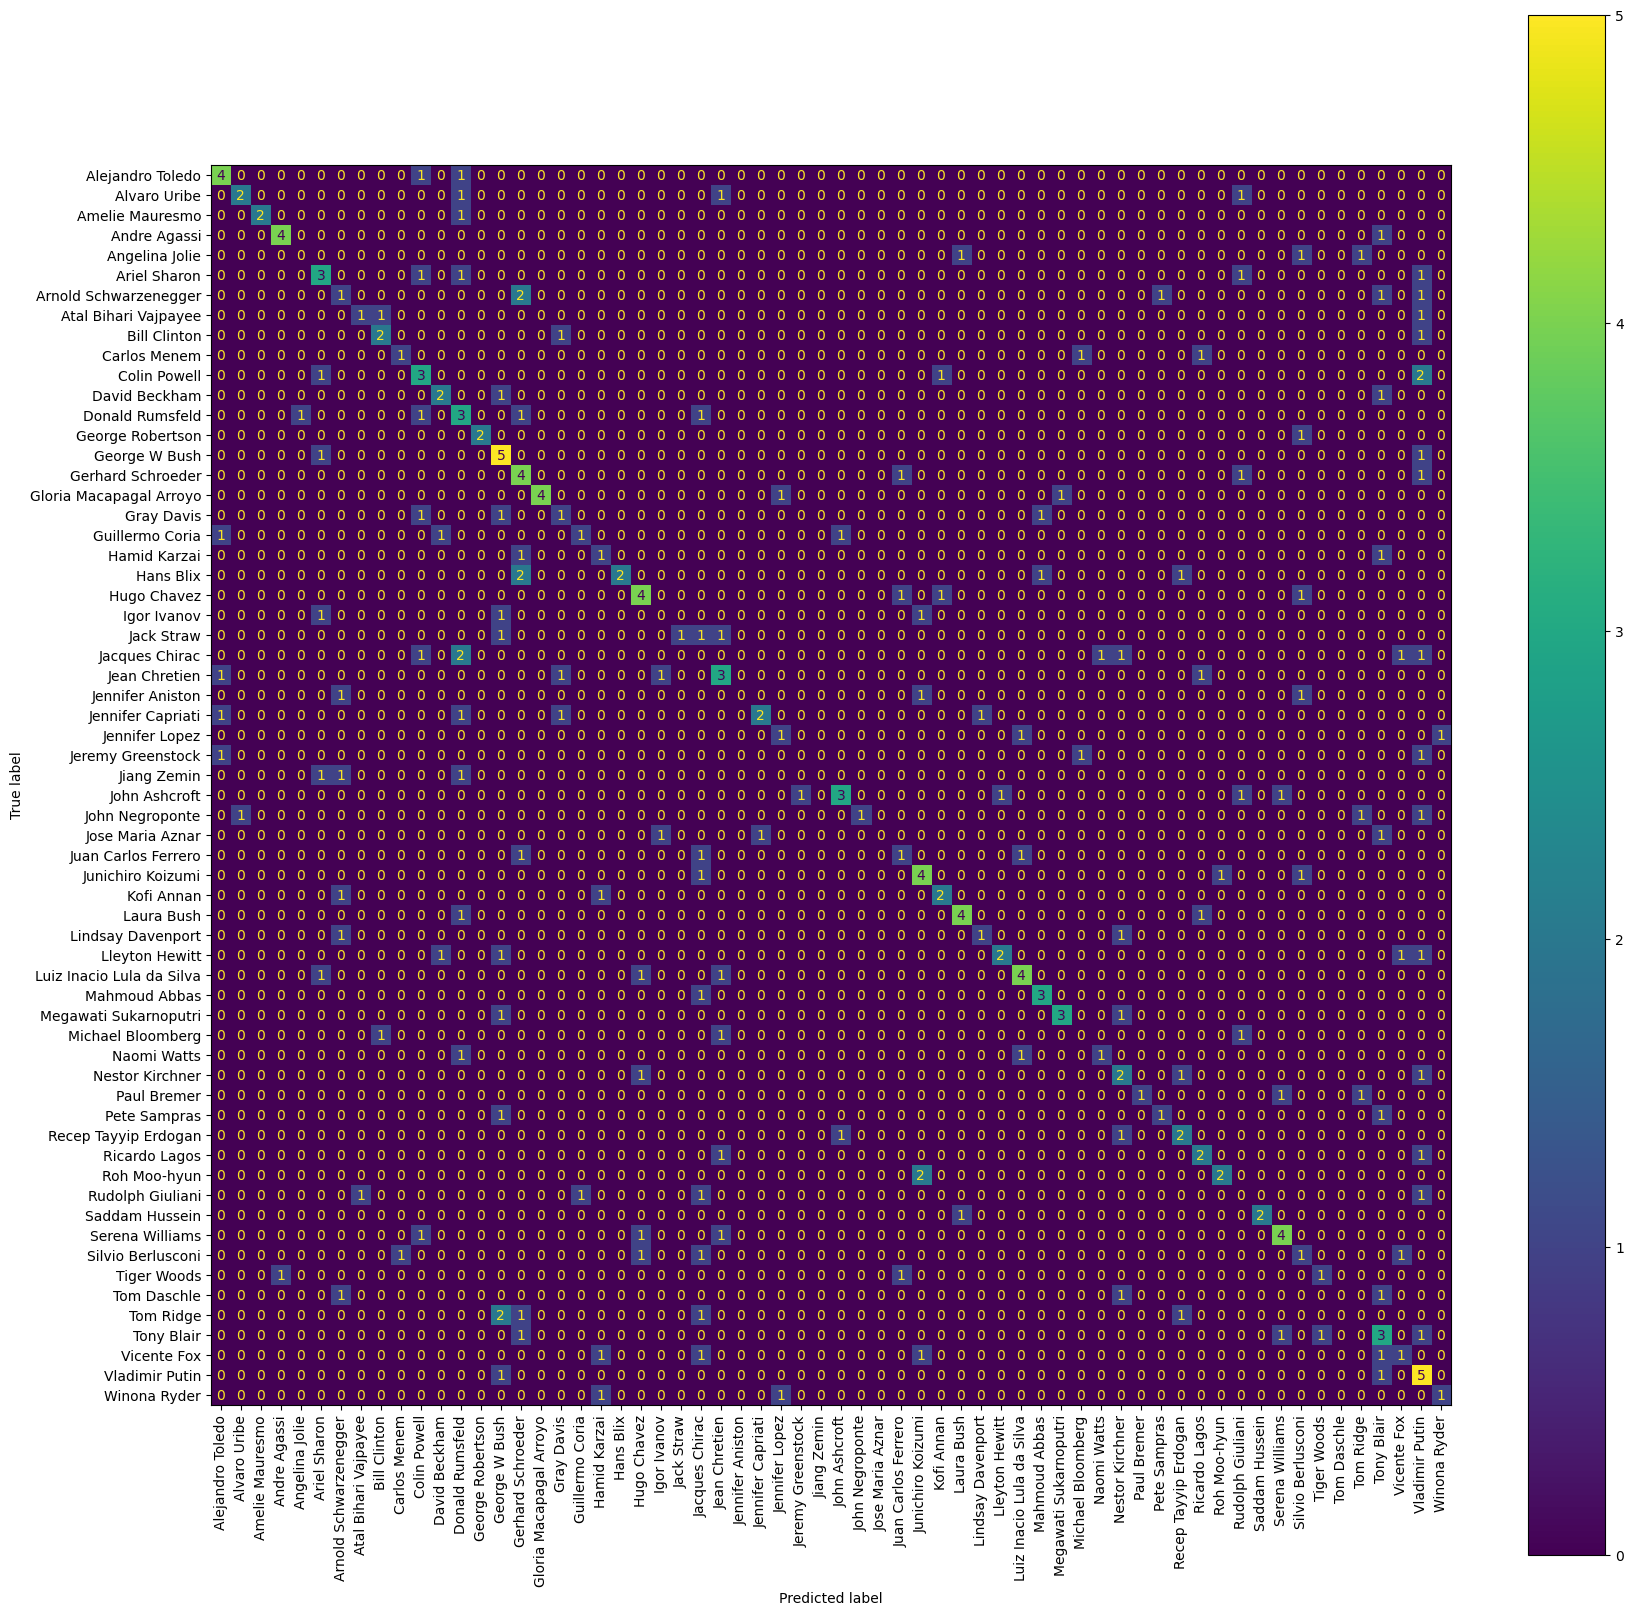

In [56]:
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=people.target_names)
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax, xticks_rotation='vertical')

#### Fit prod model

In [57]:
# fit model on combined X_train and X_val
X_train_prod = np.vstack((X_train_pca, X_val_pca))
y_train_prod = np.hstack((y_train, y_val))
best_clf.fit(X_train_prod, y_train_prod)

LogisticRegression(C=10)

# Question 6
Pretend it is next month, and you have to score the new data! (Your X_test)

- Assume that we have painstakenly annotated the data manually (y_test). 

- Evaluate your prod model on (X_test, y_test) - Report the results
- Report any noteworthy insights (such as class performance imbalances) and write what it might mean for your model in production.

In [58]:
X_test_pca = pca.transform(X_test)

In [59]:
# evaluate model on test set
y_pred_test = best_clf.predict(X_test_pca)
print(f"Test set score: {accuracy_score(y_test, y_pred_test):.2f}")
print(classification_report(y_test, y_pred_test, target_names=people.target_names, zero_division=0))

Test set score: 0.44
                           precision    recall  f1-score   support

         Alejandro Toledo       0.70      0.70      0.70        10
             Alvaro Uribe       0.43      0.33      0.38         9
          Amelie Mauresmo       0.75      0.60      0.67         5
             Andre Agassi       0.29      0.22      0.25         9
           Angelina Jolie       1.00      0.20      0.33         5
             Ariel Sharon       0.54      0.54      0.54        13
    Arnold Schwarzenegger       0.14      0.30      0.19        10
     Atal Bihari Vajpayee       0.80      0.67      0.73         6
             Bill Clinton       0.57      0.57      0.57         7
             Carlos Menem       0.33      0.20      0.25         5
             Colin Powell       0.38      0.38      0.38        13
            David Beckham       0.17      0.12      0.14         8
          Donald Rumsfeld       0.33      0.54      0.41        13
         George Robertson       0.67    

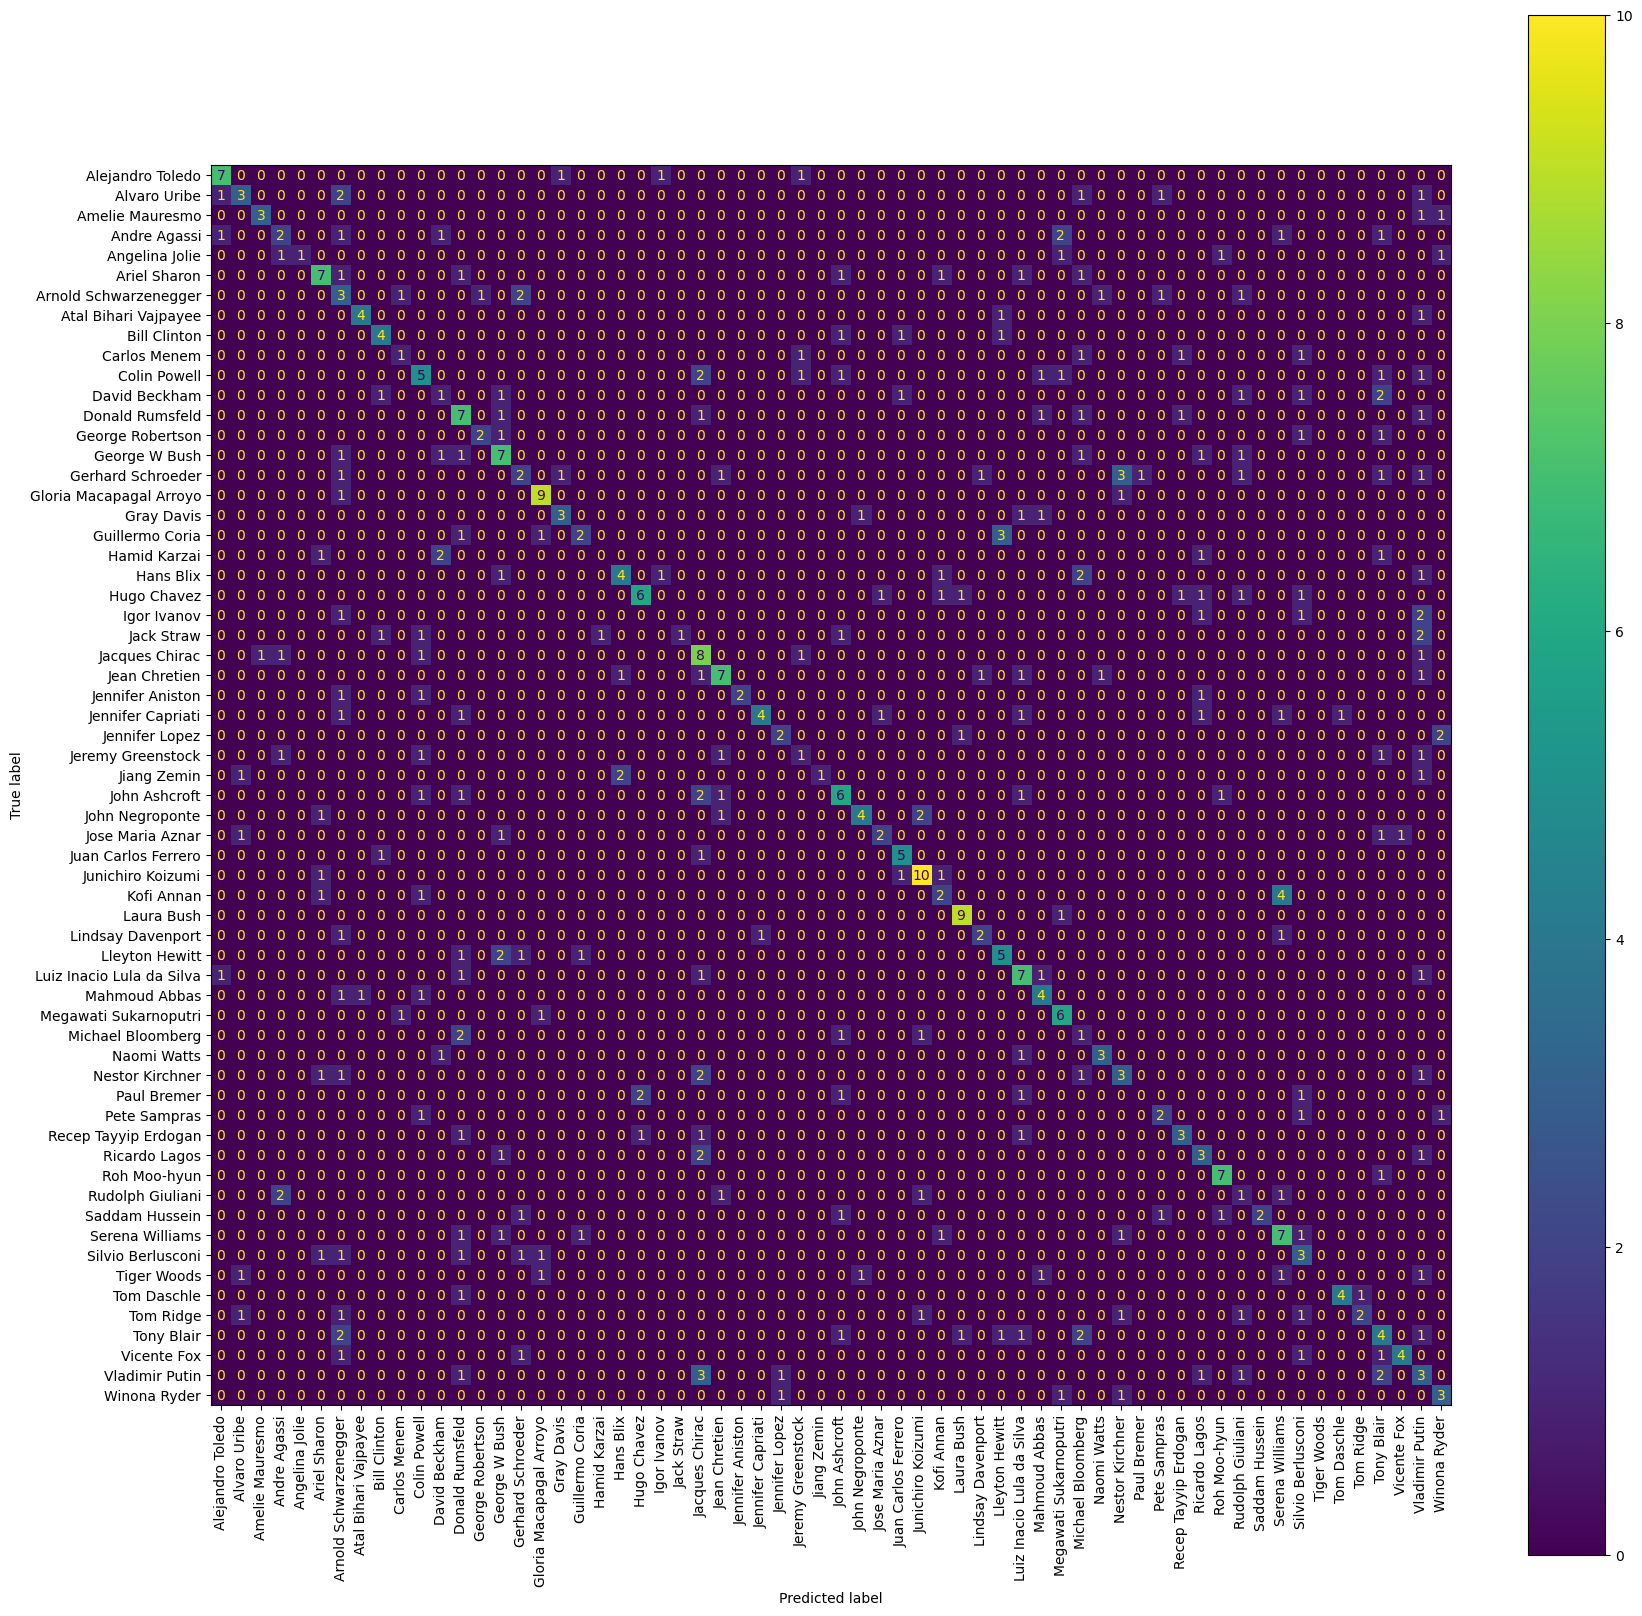

In [60]:
cm = confusion_matrix(y_test, y_pred_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=people.target_names)
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax, xticks_rotation='vertical');